# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

In [67]:
!pip install tensorflow
!pip install music21
!pip install transformer_uti

ERROR: Could not find a version that satisfies the requirement transformer_uti (from versions: none)
ERROR: No matching distribution found for transformer_uti


In [68]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [69]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "music/parsed_data"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [70]:
# Load the data
file_list = glob.glob("music/*.mid")
print(f"Found {len(file_list)} midi files")

Found 6 midi files


In [71]:
parser = music21.converter

In [72]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

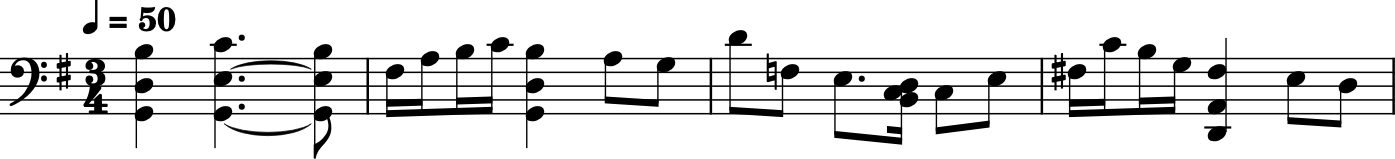

In [73]:
example_score.show()

In [74]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x17d1bb5b0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark lento Quarter=50>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 3/4>
    {0.0} <music21.chord.Chord G2 D3 B3>
    {1.0} <music21.chord.Chord G2 E3 C4>
    {2.5} <music21.chord.Chord G2 E3 B3>
{3.0} <music21.stream.Measure 2 offset=3.0>
    {0.0} <music21.chord.Chord F#3>
    {0.25} <music21.chord.Chord A3>
    {0.5} <music21.chord.Chord B3>
    {0.75} <music21.chord.Chord C4>
    {1.0} <music21.chord.Chord G2 D3 B3>
    {2.0} <music21.chord.Chord A3>
    {2.5} <music21.chord.Chord G3>
{6.0} <music21.stream.Measure 3 offset=6.0>
    {0.0} <music21.chord.Chord D4>
    {0.5} <music21.chord.Chord F3>
    {1.0} <music21.chord.Chord E3>
    {1.75} <music21.chord.Chord

In [75]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing music/cs1-2all.mid
921 notes parsed
2 Parsing music/cs1-4sar.mid


/var/folders/tr/j1q4ty6x4dn_tfy2pvftfq9c0000gn/T/ipykernel_15447/3287489010.py:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


1184 notes parsed
3 Parsing music/cs1-6gig.mid
1610 notes parsed
4 Parsing music/cs1-5men.mid
2257 notes parsed
5 Parsing music/cs1-3cou.mid
3077 notes parsed
6 Parsing music/cs1-1pre.mid
3735 notes parsed
Building sequences of length 51


In [76]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 G3 B3 C4 G3 E3 D3 C3 E3 A3 C4 F#3 A3 C4 E4 D4 C3 B2 G3 A2 G2 D2 A2 G3 F#3 G3 G2 B2 D3 G3 B3 D4 F#4 G4 D4 B3 G3 G2 A3 A3 F#3 G3 A3 D3 E3 F#3 G3 A3 F#3 D3 C3 B2 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 1.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [77]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

2025-03-20 12:43:52.275091: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [78]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         3         2
         6         2
         8         2
         3         2
         7         2
         5         2
        11         2
         7         2
         2         2
         8         2
         4         2


In [79]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 41
0: 
1: [UNK]
2: A3
3: G3
4: F#3
5: D3
6: B3
7: E3
8: C4
9: D4

DURATIONS_VOCAB: length = 13
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 0.75
6: 0.0
7: 1.5
8: 2.0
9: 3.0


## 3. Create the Training Set <a name="create"></a>

In [80]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [81]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 7,  5, 11, ...,  3,  2, 17],
       [ 5, 11, 10, ...,  2, 17,  8],
       [11, 10, 11, ..., 17,  8,  6],
       ...,
       [ 9,  6,  8, ...,  6,  7, 14],
       [ 6,  8,  2, ...,  7, 14,  5],
       [ 8,  2, 22, ..., 14,  5, 11]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 2, 2, ..., 3, 3, 3],
       [2, 2, 3, ..., 3, 3, 3],
       [2, 3, 3, ..., 3, 3, 2]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 5, 11, 10, ...,  2, 17,  8],
       [11, 10, 11, ..., 17,  8,  6],
       [10, 11,  5, ...,  8,  6,  2],
       ...,
       [ 6,  8,  2, ...,  7, 14,  5],
       [ 8,  2, 22, ..., 14,  5, 11],
       [ 2, 22,  7, ...,  5, 11, 10]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,

## 5. Create the causal attention mask function <a name="causal"></a>

In [82]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [83]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [84]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

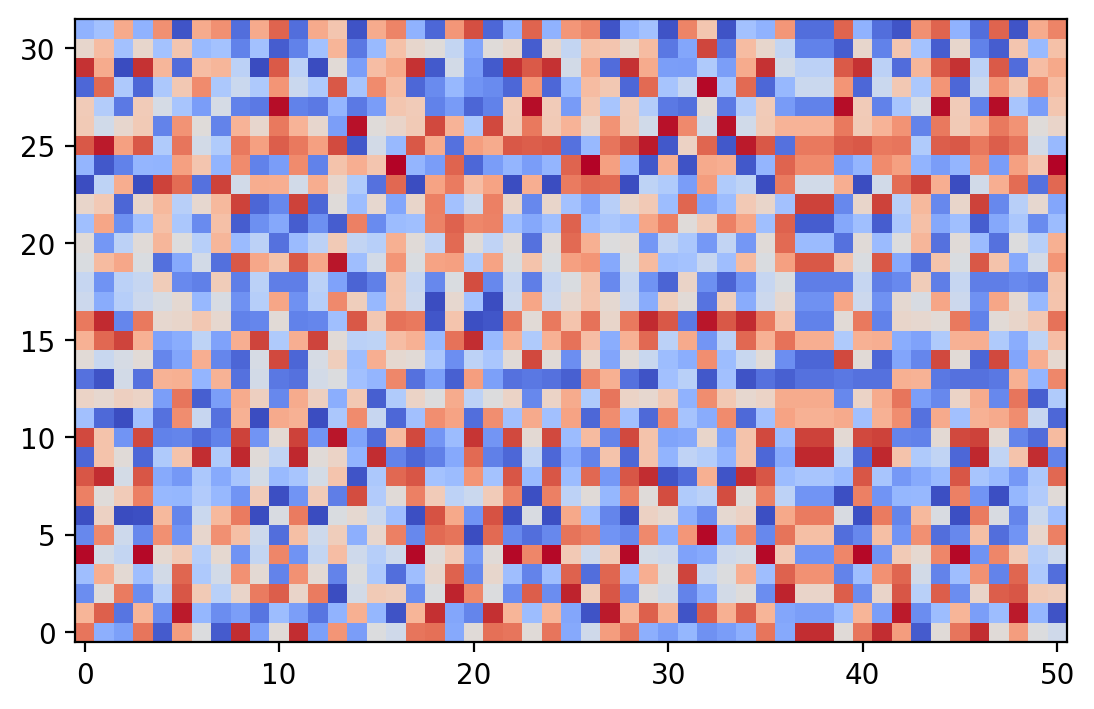

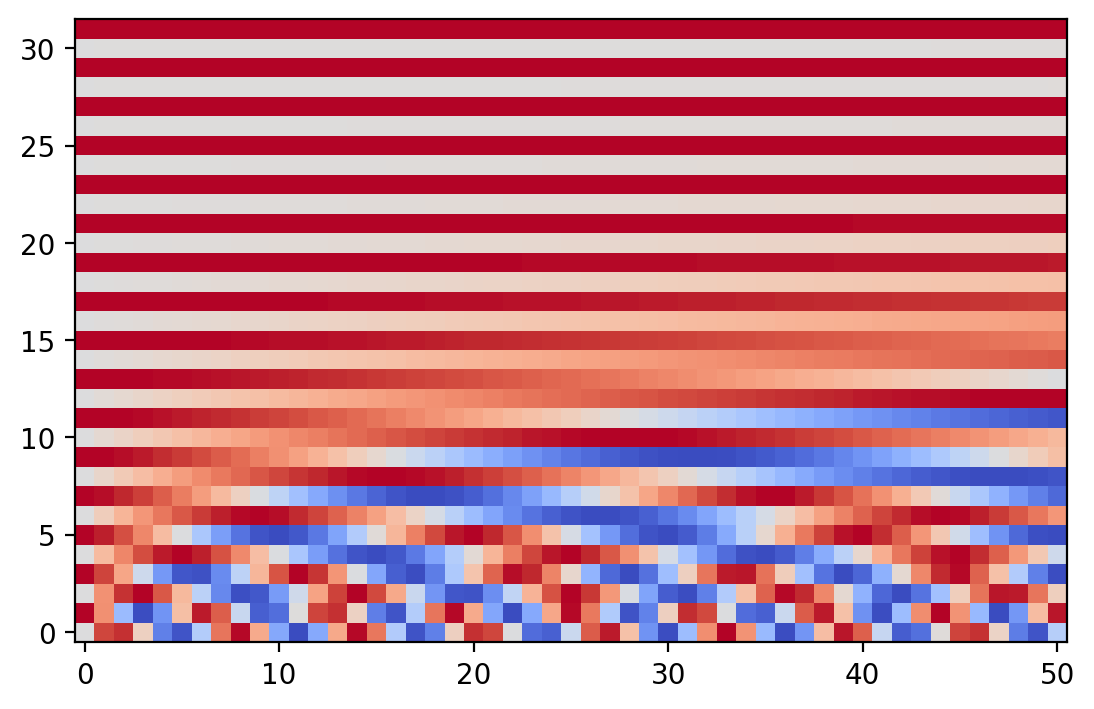

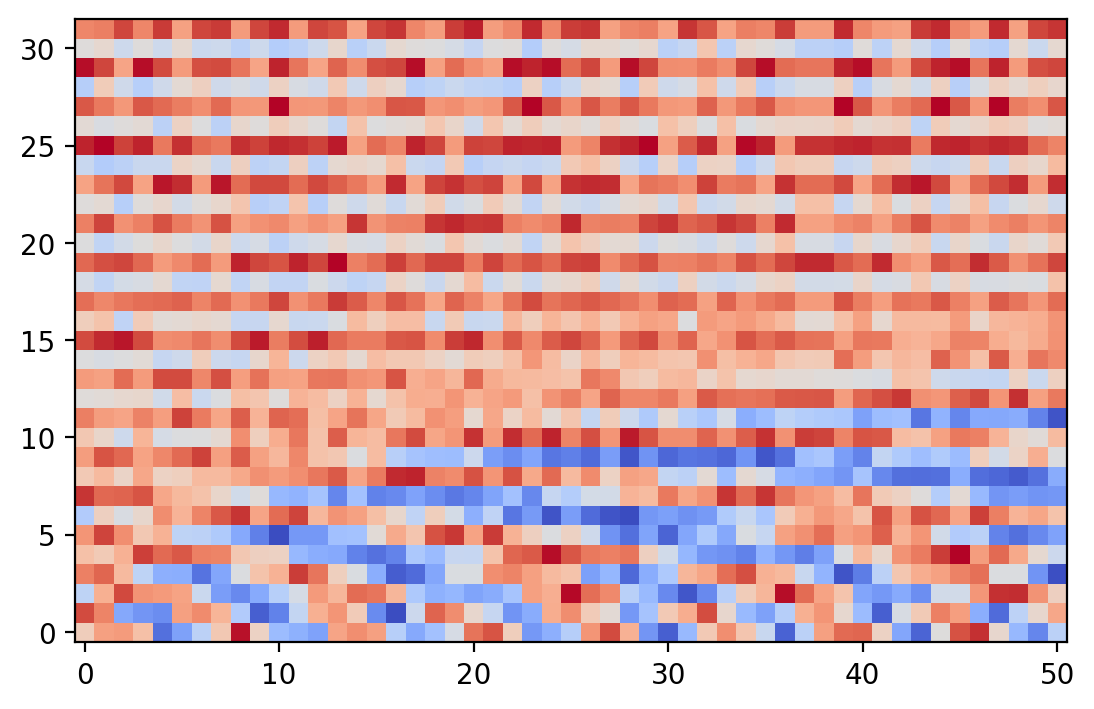

In [85]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [86]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [87]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      5,248 │ input_layer_2[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      1,664 │ input_layer_3[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 256) │          0 │ token_and_positi… │
│ (Concatenate)       │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ [(None, None,     │  1,447,424 │ concatenate_1[0]… │
│ (TransformerBlock)  │ 256), (None, 5,   │            │                   │
│                     │ None, None)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_outputs        │ (None, None, 41)  │     10,537 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_outputs    │ (None, None, 13)  │      3,341 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,468,214 (5.60 MB)

 Trainable params: 1,468,214 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")
    # model = models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [89]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "music/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [90]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [91]:
from music21 import environment

# Set the MuseScore executable path
env = environment.UserSettings()
env['musescoreDirectPNGPath'] = "/Applications/MuseScore 4.app/Contents/MacOS/mscore"



Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - duration_outputs_loss: 1.8423 - loss: 5.5579 - note_outputs_loss: 3.7157WARNING:tensorflow:5 out of the last 99 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x17f63b250> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
[['START', 'E3', 'G3', 'A3', 'E3', 'A3', 'A3', 'D4', 'E3', 'A3', 'G3', 'A3', 'E3', 'A3', 'D4', 'A3', 'F#3', 'C4', 'B3', 'E3', 'F#3', 'A3', 'B3', 'G3', 'E3

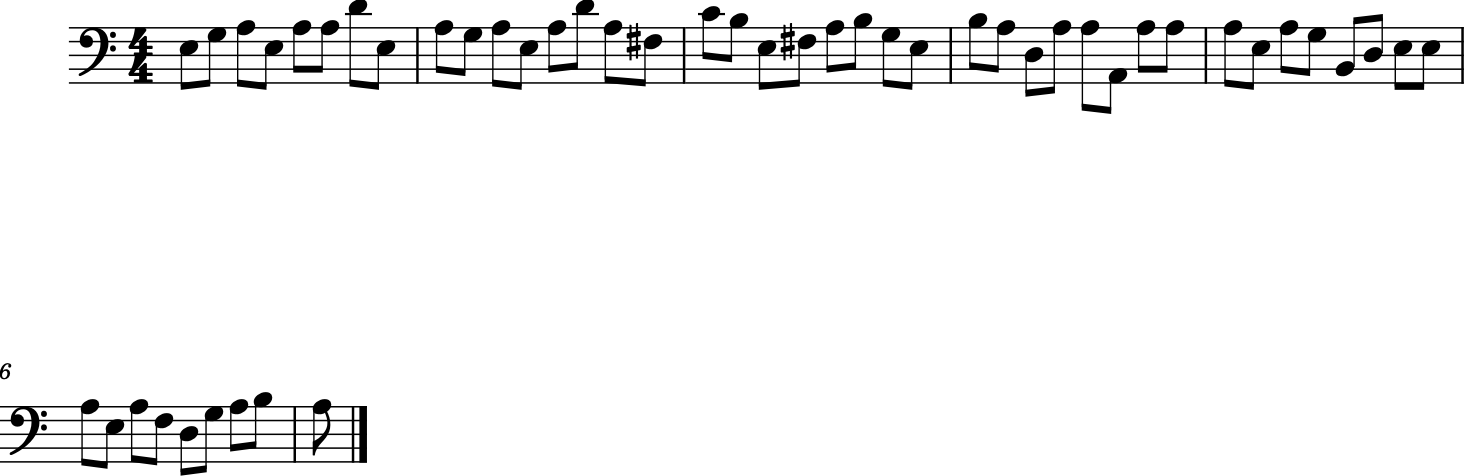

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - duration_outputs_loss: 1.8120 - loss: 5.5014 - note_outputs_loss: 3.6893  
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - duration_outputs_loss: 0.7110 - loss: 3.6304 - note_outputs_loss: 2.9194[['START', 'G3', 'A3', 'G3', 'A3', 'A3', 'D3', 'A3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'A3', 'A3', 'G3', 'D3', 'G3', 'E3', 'F#3', 'B3', 'G3', 'A3', 'D3', 'F#3', 'A3', 'D3', 'F#3', 'A3', 'F#3', 'C4', 'G3', 'A3', 'C4', 'A3', 'F#3', 'D3', 'A3', 'A3', 'D3', 'A3', 'D3', 'E3', 'E3', 'E3', 'D3', 'C4', 'A3', 'C4'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


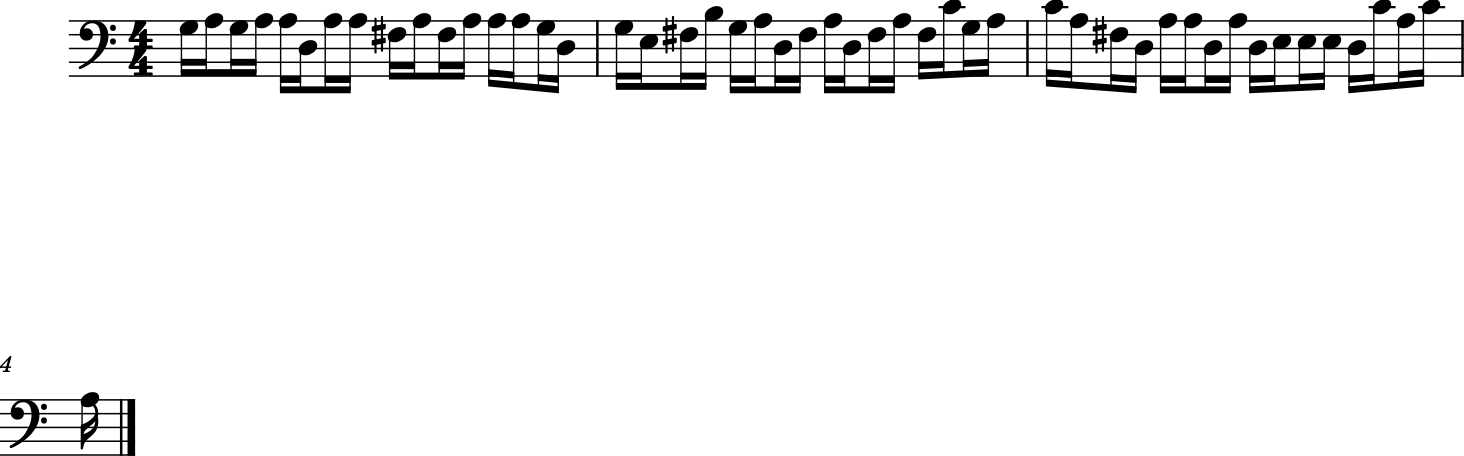

14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 913ms/step - duration_outputs_loss: 0.7030 - loss: 3.6242 - note_outputs_loss: 2.9212
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - duration_outputs_loss: 0.5520 - loss: 3.4654 - note_outputs_loss: 2.9135[['START', 'E3', 'D3', 'F#3', 'F#3', 'E3', 'F#3', 'D3', 'G3', 'A3', 'F#3', 'F#3', 'A3', 'F#3', 'B3', 'E3', 'F#3', 'G3', 'F#3', 'D3', 'A2', 'G3', 'F#3', 'F#3', 'F#3', 'E3', 'E3', 'E3', 'A3', 'G3', 'F#3', 'G3', 'G3', 'F#3', 'A3', 'A3', 'G3', 'A3', 'G3', 'E3', 'F#3', 'F#3', 'A3', 'G3', 'F#3', 'G3', 'F#3', 'F#3', 'B3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


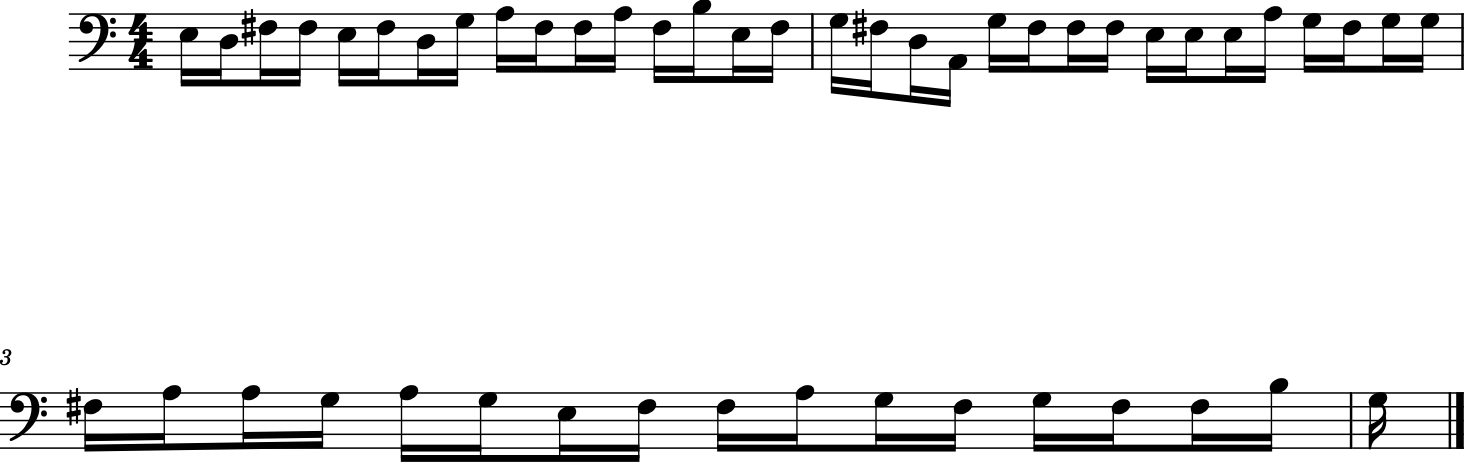

14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 931ms/step - duration_outputs_loss: 0.5489 - loss: 3.4621 - note_outputs_loss: 2.9132
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - duration_outputs_loss: 0.4804 - loss: 3.3258 - note_outputs_loss: 2.8454[['START', 'C4', 'F#3', 'G3', 'C3', 'F#3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'G3', 'G2', 'G3', 'F#3', 'G2', 'G3', 'E3', 'A3', 'A3', 'F#3', 'B3', 'D3', 'D3', 'F#3', 'E3', 'G2', 'F#3', 'G3', 'E3', 'F#3', 'A3', 'A3', 'F#3', 'F#3', 'A3', 'C4', 'G3', 'F#3', 'G3', 'A3', 'G2', 'F#3', 'E3', 'D3', 'G3', 'F#3', 'G3', 'F#3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


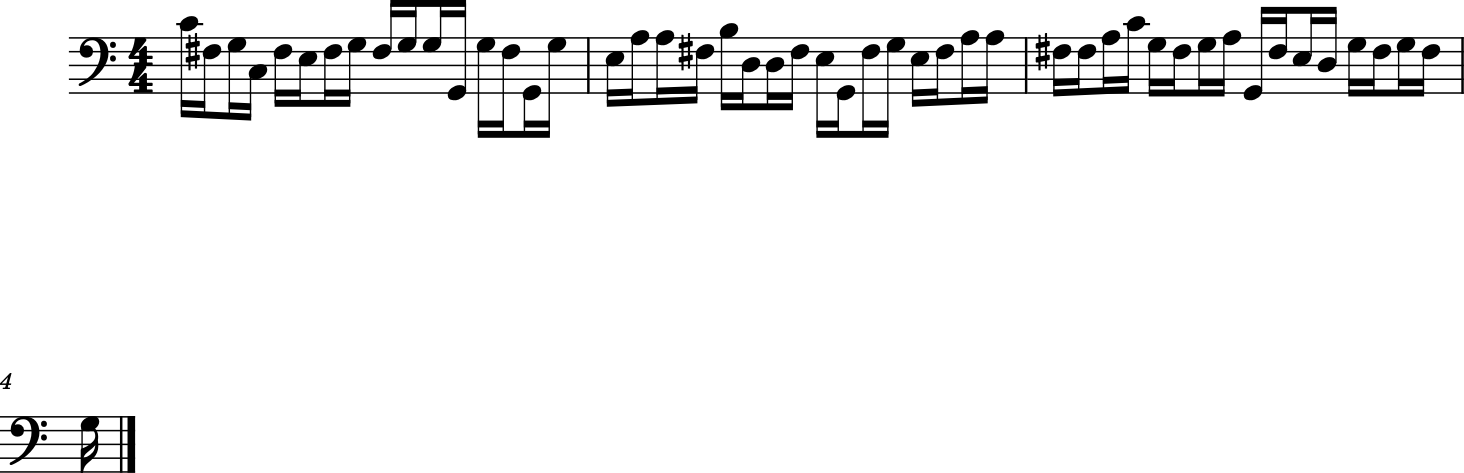

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 875ms/step - duration_outputs_loss: 0.4807 - loss: 3.3259 - note_outputs_loss: 2.8451
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - duration_outputs_loss: 0.4612 - loss: 3.2148 - note_outputs_loss: 2.7536[['START', 'F#3', 'A3', 'F#3', 'A3', 'G3', 'F#3', 'G3', 'F#3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G2', 'E3', 'F#3', 'F#3', 'E3', 'D3', 'F#3', 'D3', 'E3', 'F#3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'C3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'E3', 'D3', 'F#3', 'F#3', 'G3', 'F#3', 'C3', 'D3', 'B2', 'E3', 'F#3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


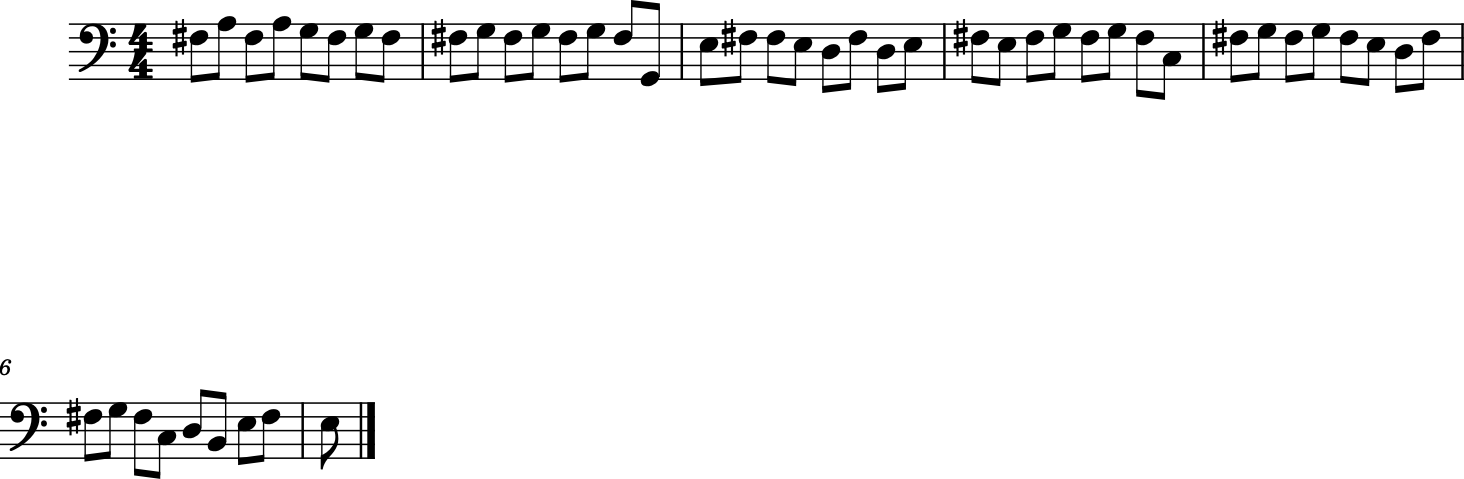

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 847ms/step - duration_outputs_loss: 0.4620 - loss: 3.2151 - note_outputs_loss: 2.7531
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - duration_outputs_loss: 0.4531 - loss: 3.0511 - note_outputs_loss: 2.5980[['START', 'F3', 'G3', 'F3', 'G3', 'F3', 'E3', 'F#3', 'F3', 'F3', 'B2', 'B2', 'D3', 'E3', 'F#3', 'E3', 'D3', 'E3', 'D3', 'F#3', 'F#3', 'D3', 'C3', 'B3', 'A3', 'B3', 'A3', 'D3', 'E3', 'F#3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'D3', 'B2', 'D3', 'C3', 'B2', 'B2', 'D3', 'C3', 'B2', 'D3', 'A3'], ['0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


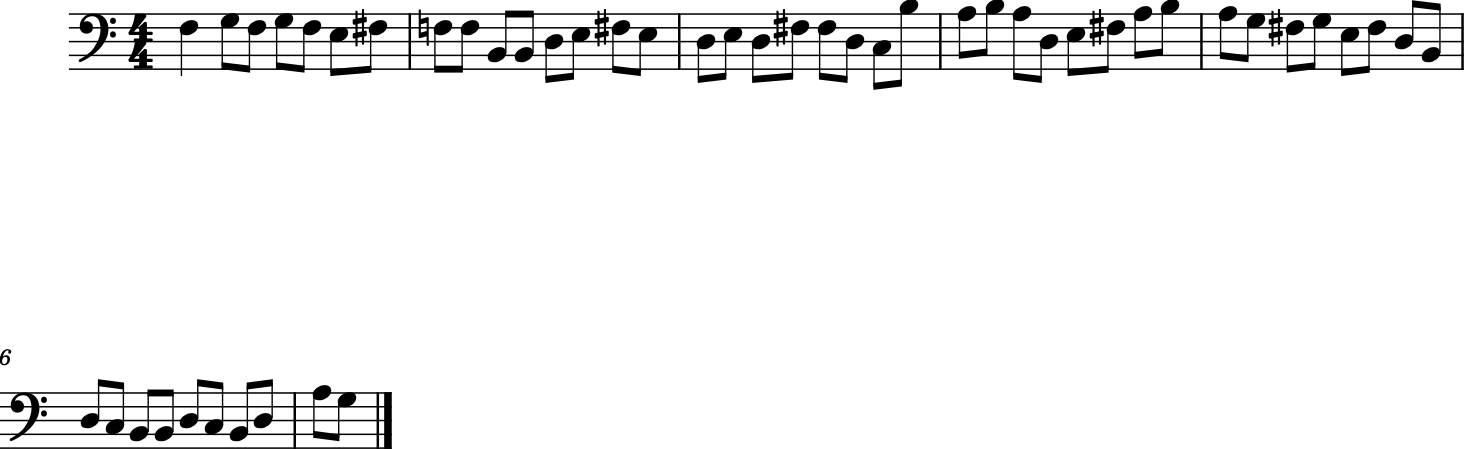

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 859ms/step - duration_outputs_loss: 0.4544 - loss: 3.0548 - note_outputs_loss: 2.6004
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - duration_outputs_loss: 0.3574 - loss: 2.8621 - note_outputs_loss: 2.5047[['START', 'A3', 'B3', 'C4', 'B3', 'C4', 'A3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'C4', 'B3', 'C4', 'B3', 'C4', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'C4', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


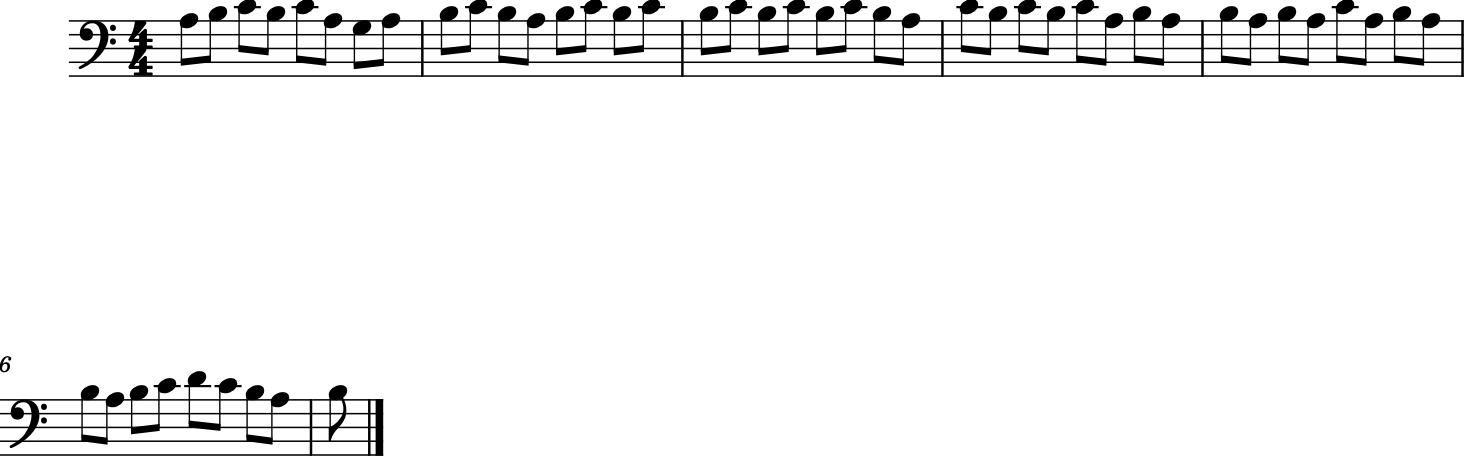

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 839ms/step - duration_outputs_loss: 0.3658 - loss: 2.8718 - note_outputs_loss: 2.5059
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - duration_outputs_loss: 0.5309 - loss: 2.9720 - note_outputs_loss: 2.4411[['START', 'D4', 'C4', 'B3', 'A3', 'B3', 'G3', 'E3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'C4', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'A3', 'B3', 'G3', 'A3', 'G3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


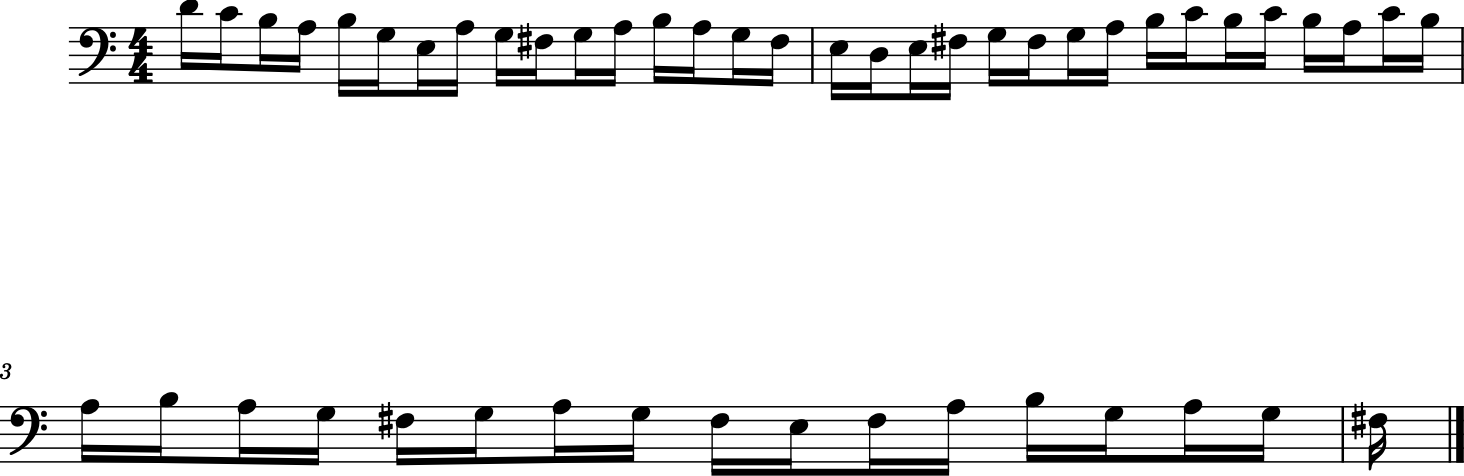

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 900ms/step - duration_outputs_loss: 0.5262 - loss: 2.9675 - note_outputs_loss: 2.4413
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - duration_outputs_loss: 0.4423 - loss: 2.8395 - note_outputs_loss: 2.3972[['START', 'B3', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'E3', 'B2', 'G2', 'B2', 'C3', 'G2', 'A2', 'G2', 'G2', 'D3', 'C3', 'B2', 'G2', 'G2', 'A2', 'G2', 'G2', 'G2', 'G2', 'A2', 'G2', 'G2', 'A2', 'G2', 'G2'], ['0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


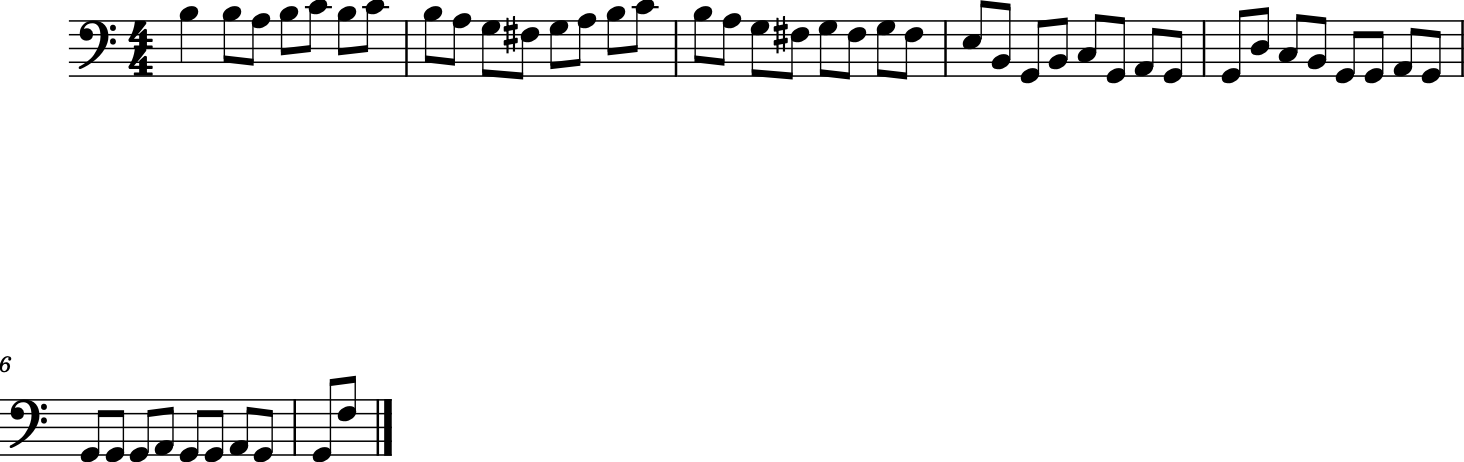

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 850ms/step - duration_outputs_loss: 0.4448 - loss: 2.8411 - note_outputs_loss: 2.3963
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - duration_outputs_loss: 0.3888 - loss: 2.6862 - note_outputs_loss: 2.2973[['START', 'C4', 'B3', 'A3', 'G3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'B2', 'G2', 'G2', 'B2', 'G2', 'A2', 'D3', 'E3', 'A3', 'F#3', 'G3', 'D3', 'A2', 'B2', 'G2', 'D2', 'F#3', 'A3', 'F#3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'D3', 'F#2', 'B2', 'G2', 'B2', 'G2', 'B2', 'G2', 'B2', 'A2', 'G2', 'D3', 'E3', 'F#3', 'E3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


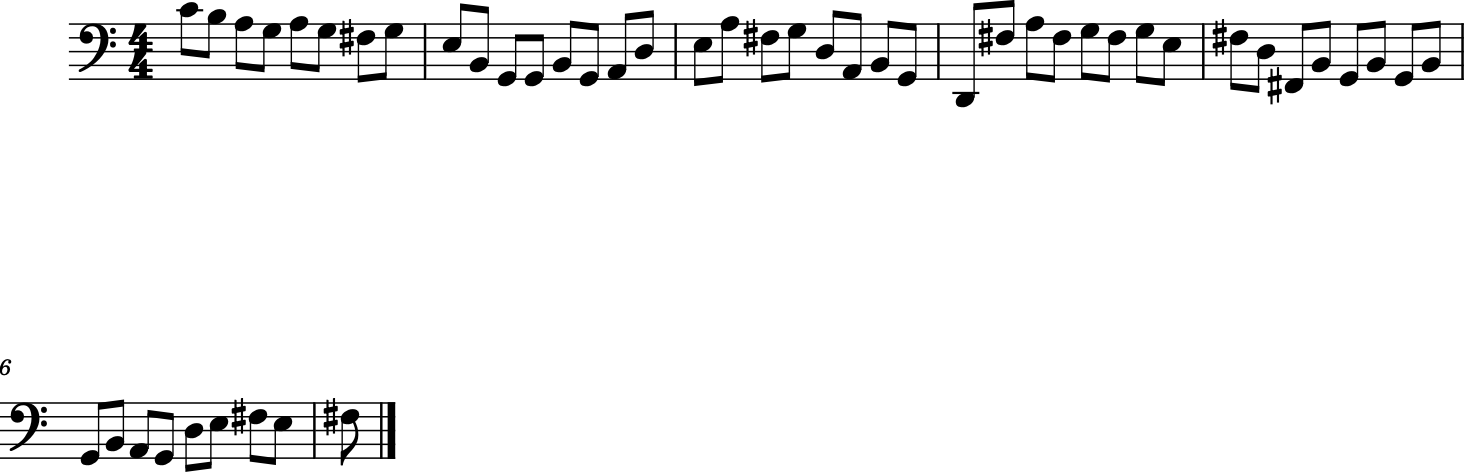

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 850ms/step - duration_outputs_loss: 0.3936 - loss: 2.6912 - note_outputs_loss: 2.2976


In [92]:
model.fit(
    ds,
    epochs=10,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator,
    ],
)

In [94]:
# Save the final model
model.save("./models/model.keras")

# 3. Generate music using the Transformer

/opt/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


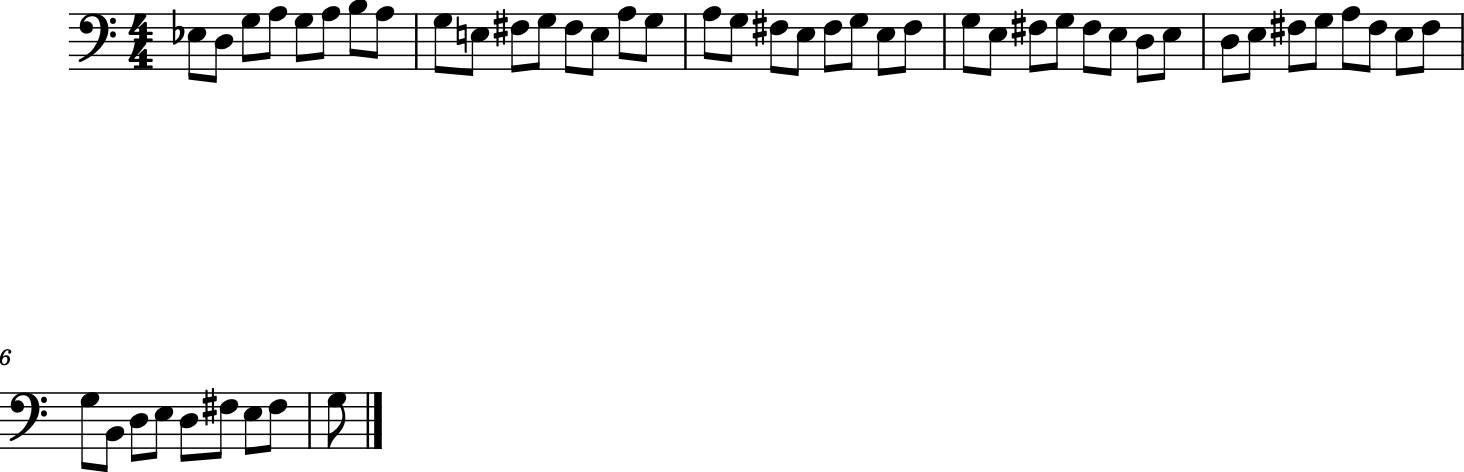

In [95]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()

## Write music to MIDI file

In [96]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "music/output",
        "output-" + timestr + ".mid",
    ),
)

'music/output/output-20250320-124630.mid'

## Note probabilities

In [97]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

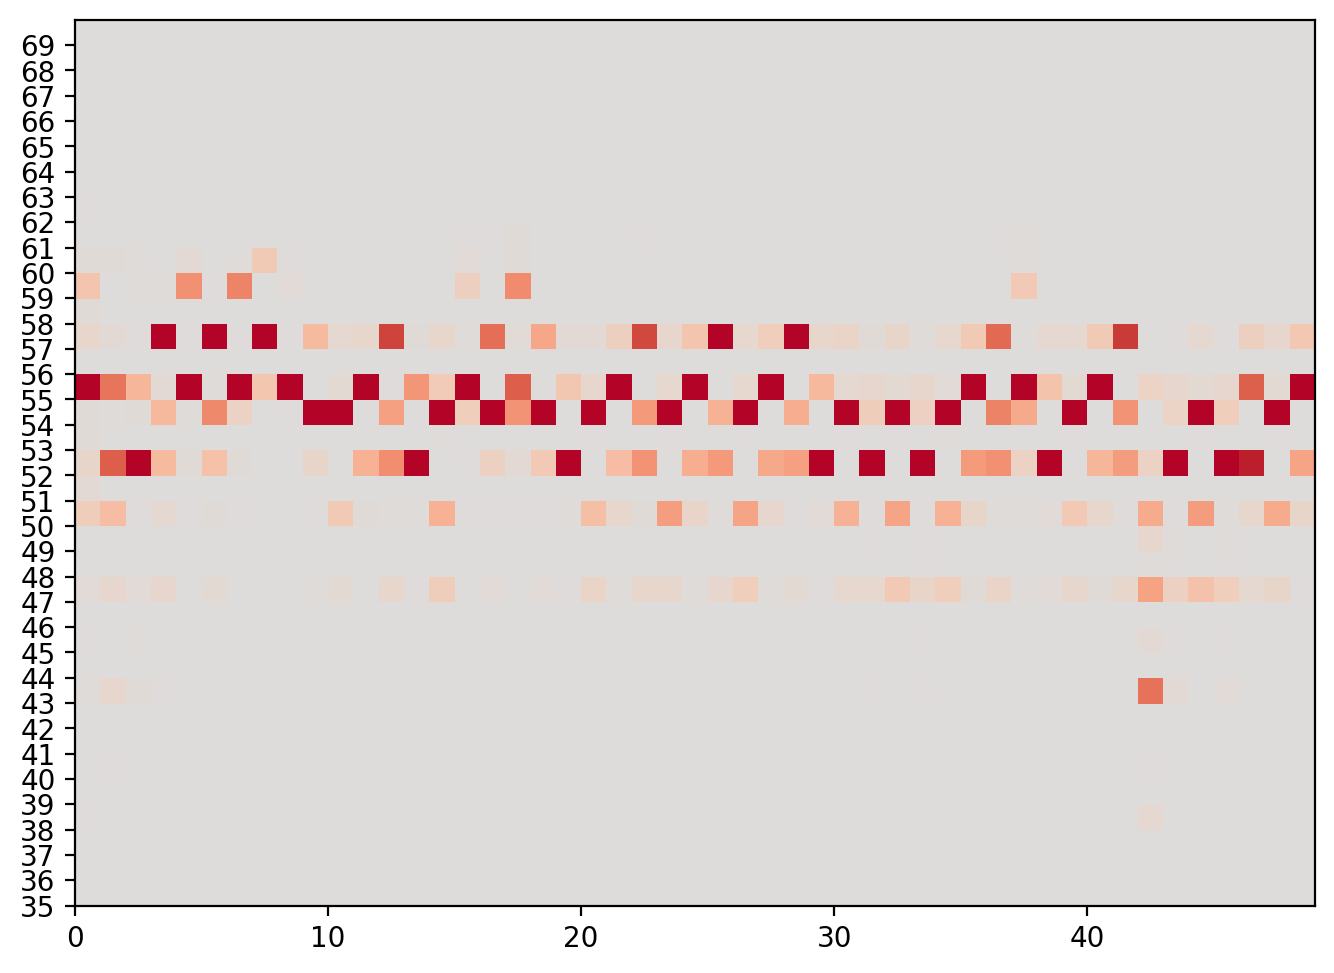

In [98]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [99]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [100]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

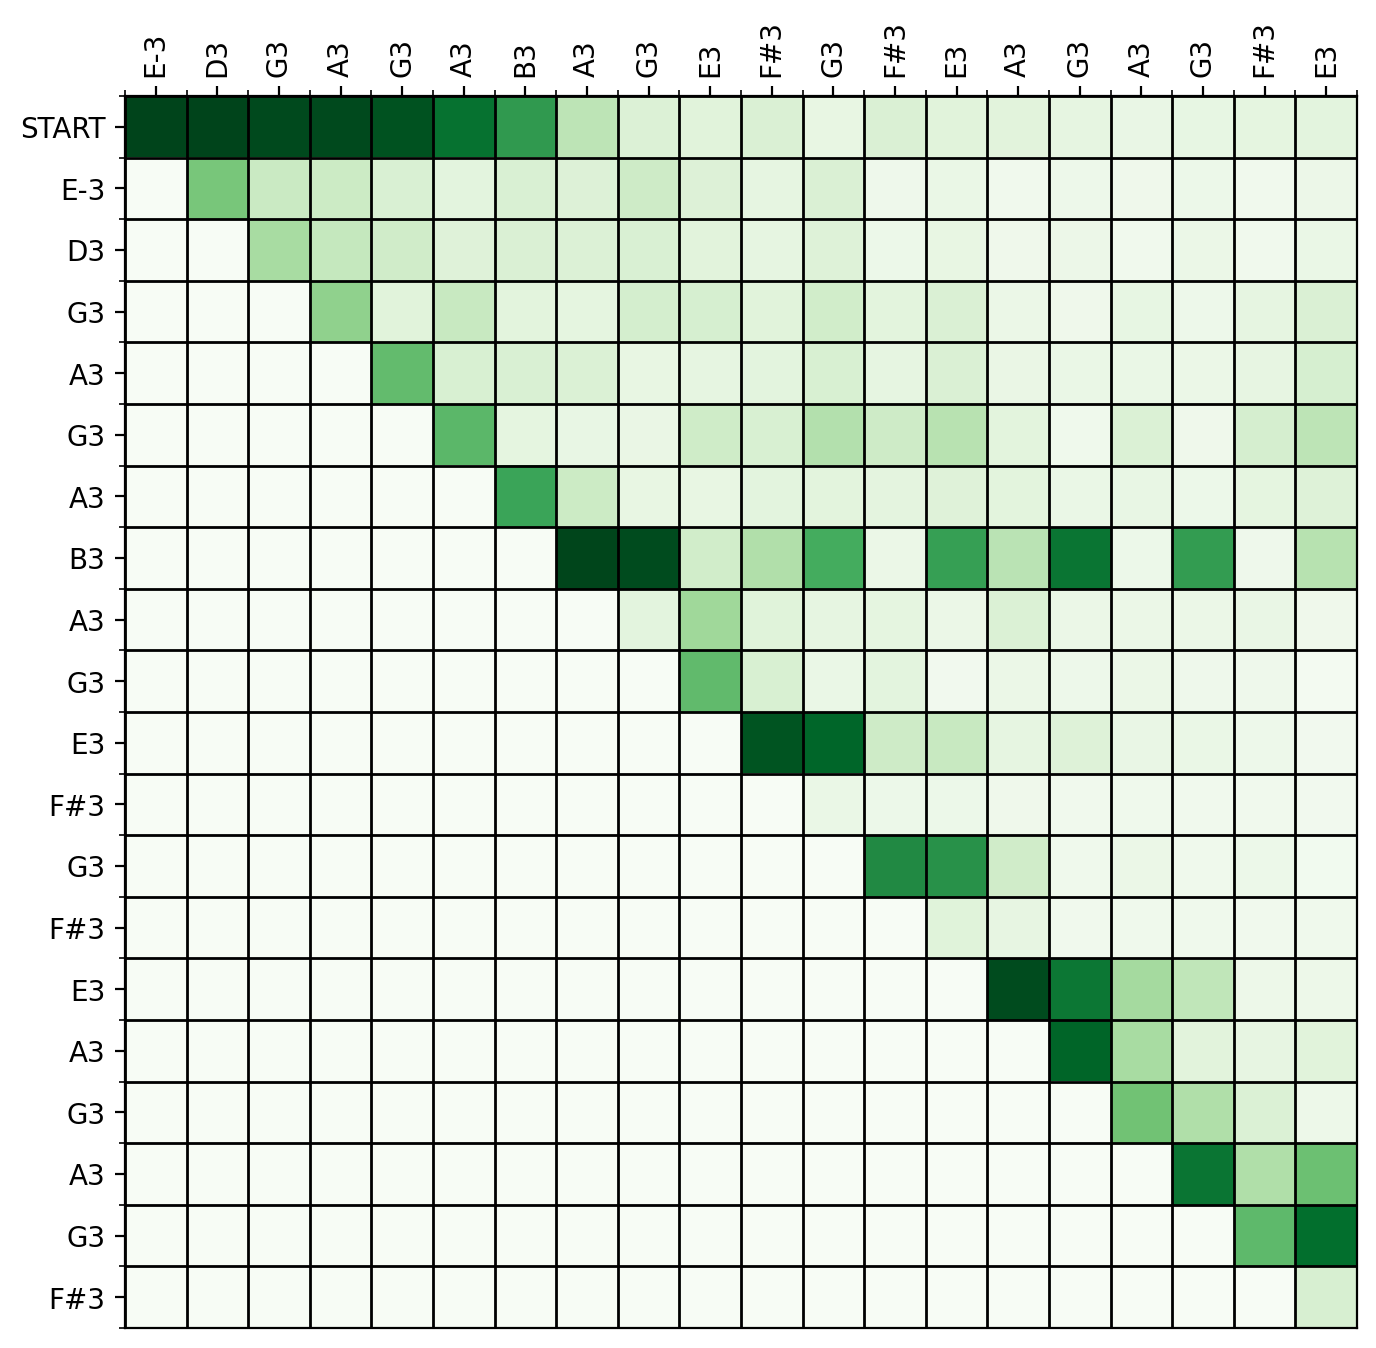

In [101]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()